In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [2]:
from torchvision.models import vgg16_bn

In [3]:
path  = Path('data/artists/')
path_hr = path/'FiveK_C'
path_lr = path/'crappy'

In [4]:
il = ImageList.from_folder(path_hr)

In [ ]:
arch = models.resnet34
tfms = get_transforms()

In [6]:
src = ImageImageList.from_folder(path_lr)

In [8]:
src = src.split_by_rand_pct(0.1, seed=42)

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/(str(x.name).split('_')[0]+'.jpg'))
           .transform(None, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [10]:
data = get_data(bs,size)

In [11]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [13]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [14]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [15]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


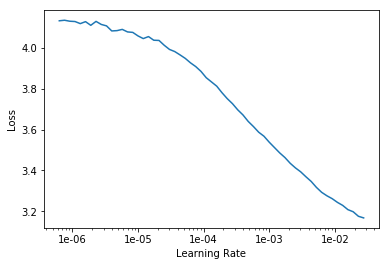

In [23]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-3

In [17]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9,cycs=10):
    learn.fit_one_cycle(cycs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.740065,1.730462,0.295076,0.224965,0.243415,0.083323,0.302429,0.459064,0.122190,41:28
1,1.675786,1.638412,0.258370,0.222126,0.237426,0.081065,0.283303,0.437997,0.118126,41:30
2,1.621517,1.585827,0.241860,0.220140,0.234376,0.079546,0.270292,0.424734,0.114880,41:31
3,1.572733,1.580928,0.245648,0.221345,0.234186,0.080010,0.265779,0.419495,0.114464,41:31
4,1.532021,1.508424,0.219230,0.216254,0.227840,0.076513,0.253764,0.404764,0.110057,41:32
5,1.512697,1.487373,0.214950,0.214381,0.225776,0.074898,0.251863,0.398121,0.107384,41:31
6,1.474840,1.453630,0.202761,0.213709,0.223821,0.074578,0.243284,0.389738,0.105739,41:31
7,1.440561,1.444361,0.204991,0.215470,0.224336,0.074728,0.235149,0.384835,0.104852,41:32
8,1.423012,1.405367,0.191448,0.212213,0.219910,0.072267,0.231011,0.377085,0.101433,41:32
9,1.302550,1.302770,0.172254,0.208392,0.212373,0.067814,0.202779,0.345891,0.093266,41:34


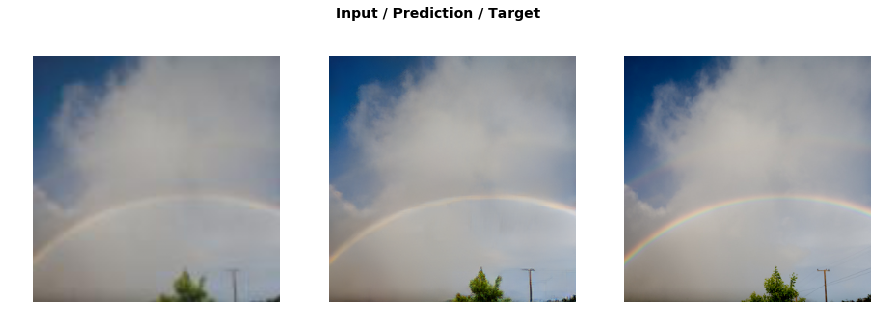

In [28]:
do_fit('1a', slice(lr*10))

In [50]:
learn.load('1a')
learn.unfreeze()

In [ ]:
do_fit('1b', slice(1e-5,lr),cycs=10)

In [53]:
learn.save('1b')

In [18]:
data = get_data(4,size*2)

In [22]:
learn.data = data
learn.freeze()
gc.collect()

14

In [ ]:
learn.load('1b');

In [ ]:
do_fit('2a',cycs=3)

In [25]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3,cycs=8)

In [27]:
learn.save('2b')

In [ ]:
learn.load('2b');